In [69]:
import os
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
import torch.nn as nn

verbose = False
NUM_TRAIN = 150
NUM_TRAIN_REPEATS = 1
NUM_EPOCHS = 5_000
RAW_SAMPLES = 20
NUM_EPS_SAMPLES = 200
EPS = 2
MU_INIT = 0.0
STD_INIT = 1.

class BNN(PyroModule):
    def __init__(self, input_dim=2, hidden_dim=50):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](input_dim, hidden_dim) # Input to hidden layer
        self.linear2 = PyroModule[nn.Linear](hidden_dim, 1) # Hidden to output layer
        self.activation = nn.ReLU()        

        self.linear1.weight = PyroSample(dist.Normal(0., STD_INIT).expand([hidden_dim, input_dim]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., STD_INIT).expand([hidden_dim]).to_event(1))
        self.linear2.weight = PyroSample(dist.Normal(0., STD_INIT).expand([1, hidden_dim]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., STD_INIT).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.linear1(x))
        mean = self.linear2(x).squeeze(-1)
        # sigma = pyro.sample("sigma", dist.Uniform(0., STD_INIT))
        sigma = pyro.sample("sigma", dist.LogNormal(0., STD_INIT))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# Define Noisy Objective Function
def expensive_function(x):
    """The 1st column of x gives the nominal inputs, 2nd column gives the noise"""
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    # Add some additional noise we want to capture via Bayesian layers
    std = 0.1
    extra_noise = torch.normal(mean=torch.zeros(x.shape[0]), std=std)
    return noised_value + extra_noise

In [72]:
# Generate Training Data
train_x = torch.empty(NUM_TRAIN, 2)
train_x[:,0].uniform_(-2,2)
train_x[:,1].uniform_(-EPS, EPS)
train_x = train_x.repeat((NUM_TRAIN_REPEATS,1)) # Generate repeats of the initial points to help learn variance
train_y  = expensive_function(train_x)
    
model = BNN(input_dim=2, hidden_dim=50)
# guide = AutoDiagonalNormal(model)
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for epoch in range(NUM_EPOCHS):
    # calculate the loss and take a gradient step
    loss = svi.step(train_x, train_y)
    if epoch % (int(NUM_EPOCHS/10)) == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(train_x)))

[iteration 5000] loss: 4.4557
[iteration 5000] loss: 3.3034
[iteration 5000] loss: 2.4571
[iteration 5000] loss: 3.6583
[iteration 5000] loss: 3.0725
[iteration 5000] loss: 1.8916
[iteration 5000] loss: 2.2349
[iteration 5000] loss: 2.0258
[iteration 5000] loss: 1.7714
[iteration 5000] loss: 1.8659


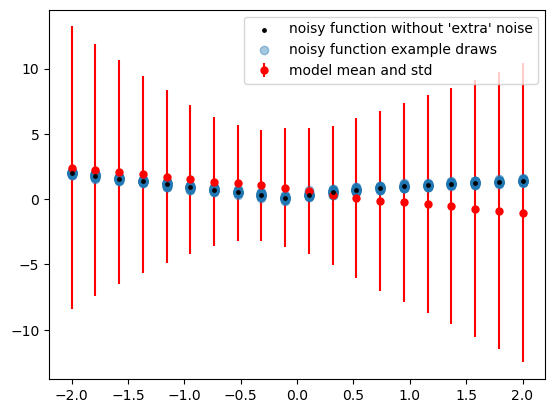

In [73]:
def function_without_extra_noise(x):
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    return noised_value 

x_repeats = 30
train_x = torch.empty(20, 2)
# train_x[:,0].uniform_(-2,2)
train_x[:,0] = torch.linspace(-2,2,train_x.shape[0])
# train_x[:,1].uniform_(-EPS, EPS)
train_x[:,1] = torch.zeros(train_x.shape[0]) 

with torch.no_grad():
    mu_pred_all = torch.stack([model(train_x) for _ in range(x_repeats)])
    std = mu_pred_all.std(axis=0).squeeze()
    plt.errorbar(train_x[:,0], mu_pred_all.mean(axis=0).squeeze(), yerr=std, c='r', fmt='o', markersize=5, label='model mean and std', zorder=1)
    
    plt.scatter(train_x[:,0], function_without_extra_noise(train_x), c='k', label="noisy function without 'extra' noise", alpha=1, s=6, zorder=2)
    train_x = train_x.repeat((x_repeats,1)) 
    train_y  = expensive_function(train_x)
    plt.scatter(train_x[:,0], train_y, label='noisy function example draws', alpha=0.4)
    plt.legend()
    plt.show()

Epoch 0, Loss: 2.0284
Epoch 200, Loss: 0.1923
Epoch 400, Loss: 0.0568
Epoch 600, Loss: 0.0596
Epoch 800, Loss: 0.0431
Epoch 1000, Loss: 0.0553
Epoch 1200, Loss: 0.0357
Epoch 1400, Loss: 0.0431
Epoch 1600, Loss: 0.0377
Epoch 1800, Loss: 0.0241


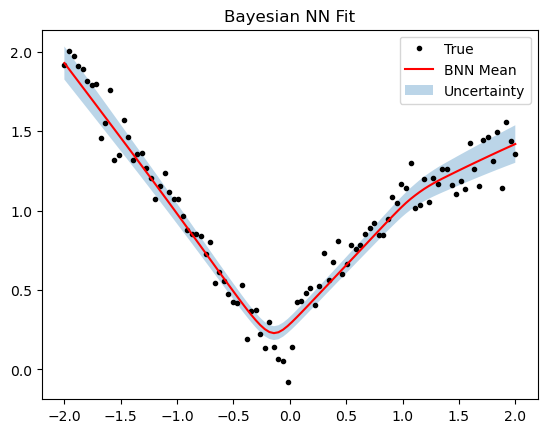

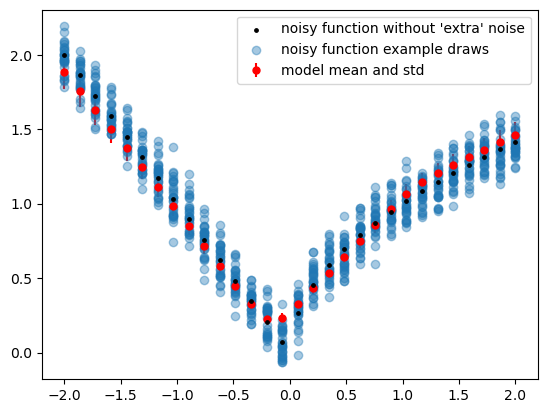

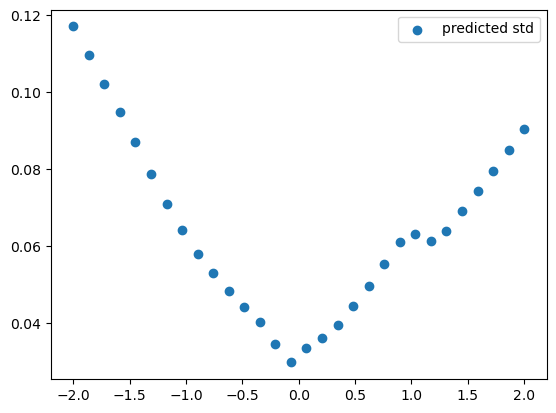

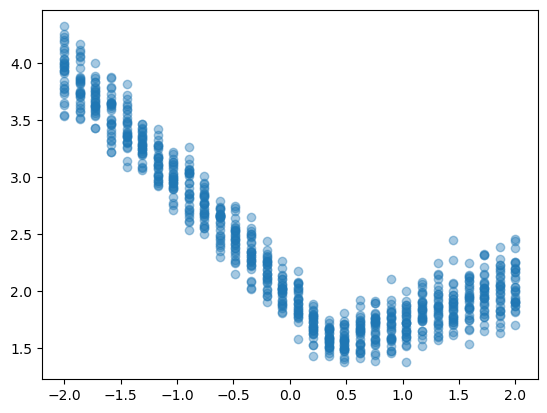

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Define Bayesian Linear Layer
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters for weights
        self.mu_weight = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.rho_weight = nn.Parameter(torch.Tensor(out_features, in_features).normal_(-3, 0.1))

        self.mu_bias = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.rho_bias = nn.Parameter(torch.Tensor(out_features).normal_(-3, 0.1))

    def forward(self, x):
        std_weight = torch.log1p(torch.exp(self.rho_weight))
        std_bias = torch.log1p(torch.exp(self.rho_bias))

        weight_eps = torch.randn_like(std_weight)
        bias_eps = torch.randn_like(std_bias)

        weight = self.mu_weight + std_weight * weight_eps
        bias = self.mu_bias + std_bias * bias_eps

        return F.linear(x, weight, bias)

    def kl_loss(self):
        std_weight = torch.log1p(torch.exp(self.rho_weight))
        std_bias = torch.log1p(torch.exp(self.rho_bias))

        kl_weight = 0.5 * (std_weight.pow(2) + self.mu_weight.pow(2) - 1 - torch.log(std_weight.pow(2) + 1e-8)).sum()
        kl_bias = 0.5 * (std_bias.pow(2) + self.mu_bias.pow(2) - 1 - torch.log(std_bias.pow(2) + 1e-8)).sum()

        return kl_weight + kl_bias

# Define full model
class BNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=50):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_dim)
        self.blinear2 = BayesianLinear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.blinear1(x))
        return self.blinear2(x)

    def kl_loss(self):
        return self.blinear1.kl_loss() + self.blinear2.kl_loss()
    
    def posterior_robust(self, X_design, num_eps_samples=10, eps=0.1):
        """ Estimate robustness measure at each design point """
        robust_measures = torch.empty((X_design.shape[0], 1))
        for i, X_d in enumerate(X_design):
            X = torch.empty((num_eps_samples, 2))
            X[:,0] = X_d.repeat(num_eps_samples)
            X[:,1].uniform_(-eps, eps)
            outputs = self.forward(X)
            robust_measures[i] = torch.max(outputs, axis=0).values
        return robust_measures

# Loss function

def sample_elbo(model, x, y, criterion, sample_nbr=3, complexity_cost_weight=1e-6):
    total_nll = 0.0
    total_kl = 0.0

    for _ in range(sample_nbr):
        preds = model(x).squeeze(1)
        total_nll += criterion(preds, y)

    nll = total_nll / sample_nbr
    total_kl = model.kl_loss()
    loss = nll + complexity_cost_weight * total_kl
    return loss

# Example usage
if __name__ == '__main__':
    import numpy as np

    torch.manual_seed(0)
    np.random.seed(0)

    def expensive_function(x):
        noised_x = torch.sum(x, dim=1)
        noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
        std = 0.1
        extra_noise = torch.normal(mean=torch.zeros(x.shape[0]), std=std)
        return noised_value + extra_noise

    NUM_TRAIN = 150
    NUM_EPOCHS = 2000
    EPS = 2

    # Generate training data
    x_nominal = torch.FloatTensor(NUM_TRAIN).uniform_(-EPS, EPS).unsqueeze(1)
    x_noise = torch.FloatTensor(NUM_TRAIN, 1).uniform_(-EPS, EPS)
    x_input = torch.cat([x_nominal, x_noise], dim=1)
    y_train = expensive_function(x_input)

    model = BNN(input_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        optimizer.zero_grad()
        loss = sample_elbo(model, x_input, y_train, criterion, sample_nbr=3)
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    x_eval = torch.linspace(-EPS, EPS, 100).unsqueeze(1)
    x_eval_input = torch.cat([x_eval, torch.zeros_like(x_eval)], dim=1)
    preds = torch.stack([model(x_eval_input).detach().squeeze() for _ in range(100)])
    pred_mean = preds.mean(0)
    pred_std = preds.std(0)

    with torch.no_grad():
        true_values = expensive_function(x_eval_input)

    plt.figure()
    plt.plot(x_eval.numpy(), true_values.numpy(), 'k.', label="True")
    plt.plot(x_eval.numpy(), pred_mean.numpy(), 'r-', label="BNN Mean")
    plt.fill_between(x_eval.squeeze(),
                     (pred_mean - pred_std).numpy(),
                     (pred_mean + pred_std).numpy(), alpha=0.3, label="Uncertainty")
    plt.legend()
    plt.title("Bayesian NN Fit")
    plt.show()
    

def function_without_extra_noise(x):
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    return noised_value 

x_repeats = 30
train_x = torch.empty(30, 2)
# train_x[:,0].uniform_(-2,2)
train_x[:,0] = torch.linspace(-2,2,train_x.shape[0])
# train_x[:,1].uniform_(-EPS, EPS)
train_x[:,1] = torch.zeros(train_x.shape[0]) 

with torch.no_grad():
    # Bayesian / deterministic
    mu_pred_all = torch.stack([model(train_x) for _ in range(x_repeats)])
    mu_pred = mu_pred_all.mean(axis=0).squeeze()
    std = mu_pred_all.std(axis=0).squeeze()
    
    # Bayesian_1
    # mu_pred, std = model(train_x)
    # mu_pred = mu_pred.squeeze()
    # std = std.squeeze()
    
    # Gaussian / mcdropout
    # mu_pred, var_pred = model(train_x)
    # mu_pred = mu_pred.squeeze()
    # std = torch.sqrt(var_pred.squeeze())
    
    plt.errorbar(train_x[:,0], mu_pred, yerr=std, c='r', fmt='o', markersize=5, label='model mean and std', zorder=1)
    
    plt.scatter(train_x[:,0], function_without_extra_noise(train_x), c='k', label="noisy function without 'extra' noise", alpha=1, s=6, zorder=2)
    train_x = train_x.repeat((x_repeats,1)) 
    train_y  = expensive_function(train_x)
    plt.scatter(train_x[:,0], train_y, label='noisy function example draws', alpha=0.4)
    plt.legend()
    plt.show()
    
    plt.scatter(torch.unique(train_x[:, 0]), std, label='predicted std')
    plt.legend()
    plt.show()

robust_samples = model.posterior_robust(train_x[:,0], num_eps_samples=100, eps=2).squeeze(1).detach()
plt.scatter(train_x[:,0], robust_samples, alpha=0.4)
# x_reduced = torch.unique(train_x[:,0])
# robust_samples = model.posterior_robust(x_reduced, num_eps_samples=500, eps=2).squeeze(1).detach()
# plt.scatter(x_reduced, robust_samples)
plt.show()